In [2]:
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.1 MB/s eta 0:00:00


In [3]:


import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy.optimize import minimize, differential_evolution
import time
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter



In [4]:

class FuzzyEnvironmentController:


    def __init__(self):

        self.room_temp = ctrl.Antecedent(np.arange(15, 36, 1), 'room_temp')
        self.humidity = ctrl.Antecedent(np.arange(20, 81, 1), 'humidity')
        self.body_temp = ctrl.Antecedent(np.arange(35, 39.1, 0.1), 'body_temp')
        self.activity = ctrl.Antecedent(np.arange(0, 11, 1), 'activity')
        self.time_of_day = ctrl.Antecedent(np.arange(0, 25, 1), 'time_of_day')

        self.temp_control = ctrl.Consequent(np.arange(-10, 11, 1), 'temp_control')
        self.humidity_control = ctrl.Consequent(np.arange(-10, 11, 1), 'humidity_control')
        self.air_circulation = ctrl.Consequent(np.arange(0, 11, 1), 'air_circulation')

        self.room_temp['cold'] = fuzz.trimf(self.room_temp.universe, [15, 15, 21])
        self.room_temp['cool'] = fuzz.trimf(self.room_temp.universe, [18, 21, 24])
        self.room_temp['comfortable'] = fuzz.trimf(self.room_temp.universe, [22, 24, 26])
        self.room_temp['warm'] = fuzz.trimf(self.room_temp.universe, [25, 28, 31])
        self.room_temp['hot'] = fuzz.trimf(self.room_temp.universe, [29, 35, 35])

        self.humidity['dry'] = fuzz.trimf(self.humidity.universe, [20, 20, 35])
        self.humidity['comfortable'] = fuzz.trimf(self.humidity.universe, [30, 45, 60])
        self.humidity['humid'] = fuzz.trimf(self.humidity.universe, [55, 80, 80])

        self.body_temp['low'] = fuzz.trimf(self.body_temp.universe, [35, 35, 36.5])
        self.body_temp['normal'] = fuzz.trimf(self.body_temp.universe, [36, 37, 37.5])
        self.body_temp['elevated'] = fuzz.trimf(self.body_temp.universe, [37.2, 38, 39])
        self.body_temp['fever'] = fuzz.trimf(self.body_temp.universe, [38.5, 39, 39])

        self.activity['resting'] = fuzz.trimf(self.activity.universe, [0, 0, 3])
        self.activity['light'] = fuzz.trimf(self.activity.universe, [2, 4, 6])
        self.activity['moderate'] = fuzz.trimf(self.activity.universe, [5, 7, 9])
        self.activity['high'] = fuzz.trimf(self.activity.universe, [8, 10, 10])

        self.time_of_day['night'] = fuzz.trimf(self.time_of_day.universe, [0, 3, 6])
        self.time_of_day['morning'] = fuzz.trimf(self.time_of_day.universe, [5, 9, 12])
        self.time_of_day['afternoon'] = fuzz.trimf(self.time_of_day.universe, [11, 15, 18])
        self.time_of_day['evening'] = fuzz.trimf(self.time_of_day.universe, [17, 21, 24])

        self.temp_control['cool_high'] = fuzz.trimf(self.temp_control.universe, [-10, -10, -6])
        self.temp_control['cool_medium'] = fuzz.trimf(self.temp_control.universe, [-8, -5, -2])
        self.temp_control['cool_low'] = fuzz.trimf(self.temp_control.universe, [-4, -2, 0])
        self.temp_control['no_change'] = fuzz.trimf(self.temp_control.universe, [-1, 0, 1])
        self.temp_control['heat_low'] = fuzz.trimf(self.temp_control.universe, [0, 2, 4])
        self.temp_control['heat_medium'] = fuzz.trimf(self.temp_control.universe, [2, 5, 8])
        self.temp_control['heat_high'] = fuzz.trimf(self.temp_control.universe, [6, 10, 10])

        self.humidity_control['dehumidify_high'] = fuzz.trimf(self.humidity_control.universe, [-10, -10, -6])
        self.humidity_control['dehumidify_medium'] = fuzz.trimf(self.humidity_control.universe, [-8, -5, -2])
        self.humidity_control['dehumidify_low'] = fuzz.trimf(self.humidity_control.universe, [-4, -2, 0])
        self.humidity_control['no_change'] = fuzz.trimf(self.humidity_control.universe, [-1, 0, 1])
        self.humidity_control['humidify_low'] = fuzz.trimf(self.humidity_control.universe, [0, 2, 4])
        self.humidity_control['humidify_medium'] = fuzz.trimf(self.humidity_control.universe, [2, 5, 8])
        self.humidity_control['humidify_high'] = fuzz.trimf(self.humidity_control.universe, [6, 10, 10])

        self.air_circulation['low'] = fuzz.trimf(self.air_circulation.universe, [0, 0, 3])
        self.air_circulation['medium'] = fuzz.trimf(self.air_circulation.universe, [2, 5, 8])
        self.air_circulation['high'] = fuzz.trimf(self.air_circulation.universe, [7, 10, 10])

        self.rules = self.create_rules()

        self.control_system = ctrl.ControlSystem(self.rules)
        self.controller = ctrl.ControlSystemSimulation(self.control_system)

    def create_rules(self):
        rules = []

        rules.append(ctrl.Rule(self.room_temp['hot'] & self.body_temp['fever'], self.temp_control['cool_high']))
        rules.append(ctrl.Rule(self.room_temp['hot'] & self.body_temp['elevated'], self.temp_control['cool_high']))
        rules.append(ctrl.Rule(self.room_temp['hot'] & self.body_temp['normal'], self.temp_control['cool_medium']))
        rules.append(ctrl.Rule(self.room_temp['hot'] & self.body_temp['low'], self.temp_control['cool_low']))

        rules.append(ctrl.Rule(self.room_temp['warm'] & self.body_temp['fever'], self.temp_control['cool_high']))
        rules.append(ctrl.Rule(self.room_temp['warm'] & self.body_temp['elevated'], self.temp_control['cool_medium']))
        rules.append(ctrl.Rule(self.room_temp['warm'] & self.body_temp['normal'], self.temp_control['cool_low']))
        rules.append(ctrl.Rule(self.room_temp['warm'] & self.body_temp['low'], self.temp_control['no_change']))

        rules.append(ctrl.Rule(self.room_temp['comfortable'] & self.body_temp['fever'], self.temp_control['cool_medium']))
        rules.append(ctrl.Rule(self.room_temp['comfortable'] & self.body_temp['elevated'], self.temp_control['cool_low']))
        rules.append(ctrl.Rule(self.room_temp['comfortable'] & self.body_temp['normal'], self.temp_control['no_change']))
        rules.append(ctrl.Rule(self.room_temp['comfortable'] & self.body_temp['low'], self.temp_control['heat_low']))

        rules.append(ctrl.Rule(self.room_temp['cool'] & self.body_temp['fever'], self.temp_control['cool_low']))
        rules.append(ctrl.Rule(self.room_temp['cool'] & self.body_temp['elevated'], self.temp_control['no_change']))
        rules.append(ctrl.Rule(self.room_temp['cool'] & self.body_temp['normal'], self.temp_control['heat_low']))
        rules.append(ctrl.Rule(self.room_temp['cool'] & self.body_temp['low'], self.temp_control['heat_medium']))

        rules.append(ctrl.Rule(self.room_temp['cold'] & self.body_temp['fever'], self.temp_control['no_change']))
        rules.append(ctrl.Rule(self.room_temp['cold'] & self.body_temp['elevated'], self.temp_control['heat_low']))
        rules.append(ctrl.Rule(self.room_temp['cold'] & self.body_temp['normal'], self.temp_control['heat_medium']))
        rules.append(ctrl.Rule(self.room_temp['cold'] & self.body_temp['low'], self.temp_control['heat_high']))

        rules.append(ctrl.Rule(self.activity['high'], self.temp_control['cool_low']))
        rules.append(ctrl.Rule(self.activity['moderate'], self.temp_control['cool_low']))
        rules.append(ctrl.Rule(self.activity['resting'] & self.body_temp['low'], self.temp_control['heat_medium']))

        rules.append(ctrl.Rule(self.time_of_day['night'] & self.body_temp['normal'], self.temp_control['heat_low']))
        rules.append(ctrl.Rule(self.time_of_day['night'] & self.body_temp['low'], self.temp_control['heat_medium']))

        rules.append(ctrl.Rule(self.humidity['dry'] & self.body_temp['fever'], self.humidity_control['humidify_medium']))
        rules.append(ctrl.Rule(self.humidity['dry'] & self.body_temp['normal'], self.humidity_control['humidify_low']))
        rules.append(ctrl.Rule(self.humidity['comfortable'], self.humidity_control['no_change']))
        rules.append(ctrl.Rule(self.humidity['humid'] & self.body_temp['fever'], self.humidity_control['dehumidify_high']))
        rules.append(ctrl.Rule(self.humidity['humid'] & self.body_temp['elevated'], self.humidity_control['dehumidify_medium']))
        rules.append(ctrl.Rule(self.humidity['humid'] & self.body_temp['normal'], self.humidity_control['dehumidify_low']))

        rules.append(ctrl.Rule(self.activity['high'], self.air_circulation['high']))
        rules.append(ctrl.Rule(self.activity['moderate'], self.air_circulation['medium']))
        rules.append(ctrl.Rule(self.activity['light'], self.air_circulation['medium']))
        rules.append(ctrl.Rule(self.activity['resting'], self.air_circulation['low']))

        rules.append(ctrl.Rule(self.body_temp['fever'], self.air_circulation['high']))
        rules.append(ctrl.Rule(self.body_temp['elevated'], self.air_circulation['medium']))

        rules.append(ctrl.Rule(self.humidity['humid'] & self.room_temp['hot'], self.air_circulation['high']))
        rules.append(ctrl.Rule(self.humidity['humid'] & self.room_temp['warm'], self.air_circulation['medium']))

        return rules

    def compute(self, room_temp, humidity, body_temp, activity, time_of_day):
        self.controller.input['room_temp'] = room_temp
        self.controller.input['humidity'] = humidity
        self.controller.input['body_temp'] = body_temp
        self.controller.input['activity'] = activity
        self.controller.input['time_of_day'] = time_of_day

        self.controller.compute()

        return {
            'temp_control': self.controller.output['temp_control'],
            'humidity_control': self.controller.output['humidity_control'],
            'air_circulation': self.controller.output['air_circulation']
        }

    def plot_membership_functions(self):

        self.room_temp.view()
        plt.title('Room Temperature Membership Functions')
        plt.savefig('room_temp_mf.png')

        self.humidity.view()
        plt.title('Humidity Membership Functions')
        plt.savefig('humidity_mf.png')

        self.body_temp.view()
        plt.title('Body Temperature Membership Functions')
        plt.savefig('body_temp_mf.png')

        self.activity.view()
        plt.title('Activity Level Membership Functions')
        plt.savefig('activity_mf.png')

        self.time_of_day.view()
        plt.title('Time of Day Membership Functions')
        plt.savefig('time_of_day_mf.png')

        self.temp_control.view()
        plt.title('Temperature Control Membership Functions')
        plt.savefig('temp_control_mf.png')

        self.humidity_control.view()
        plt.title('Humidity Control Membership Functions')
        plt.savefig('humidity_control_mf.png')

        self.air_circulation.view()
        plt.title('Air Circulation Membership Functions')
        plt.savefig('air_circulation_mf.png')

    def plot_control_surface(self, x_var='room_temp', y_var='body_temp', z_var='temp_control',
                             x_range=None, y_range=None):
        if x_range is None:
            x_range = np.arange(
                getattr(self, x_var).universe.min(),
                getattr(self, x_var).universe.max() + 1,
                1
            )
        if y_range is None:
            y_range = np.arange(
                getattr(self, y_var).universe.min(),
                getattr(self, y_var).universe.max() + 0.1,
                0.1 if y_var == 'body_temp' else 1
            )

        x, y = np.meshgrid(x_range, y_range)
        z = np.zeros_like(x, dtype=float)

        default_inputs = {
            'room_temp': 24,
            'humidity': 50,
            'body_temp': 37,
            'activity': 3,
            'time_of_day': 12
        }

        for i in range(len(x_range)):
            for j in range(len(y_range)):
                inputs = default_inputs.copy()
                inputs[x_var] = x_range[i]
                inputs[y_var] = y_range[j]

                try:
                    result = self.compute(**inputs)
                    z[j, i] = result[z_var]
                except:
                    z[j, i] = np.nan

        # Create the figure
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        surf = ax.plot_surface(x, y, z, cmap=cm.viridis, linewidth=0, antialiased=True)

        # Customize the plot
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)
        ax.set_zlabel(z_var)
        ax.set_title(f'Control Surface: {z_var} based on {x_var} and {y_var}')

        # Add color bar
        fig.colorbar(surf, shrink=0.5, aspect=5)

        # Save the plot
        plt.savefig(f'control_surface_{x_var}_{y_var}_{z_var}.png')
        plt.close()

    def simulate_scenarios(self):
        """Simulate different scenarios to demonstrate the controller's behavior"""
        scenarios = [
            {
                'name': 'Hot room, normal body temp',
                'room_temp': 32,
                'humidity': 50,
                'body_temp': 37,
                'activity': 3,
                'time_of_day': 14
            },
            {
                'name': 'Cold room, low body temp',
                'room_temp': 17,
                'humidity': 45,
                'body_temp': 36,
                'activity': 2,
                'time_of_day': 23
            },
            {
                'name': 'Comfortable room, fever',
                'room_temp': 24,
                'humidity': 40,
                'body_temp': 38.5,
                'activity': 1,
                'time_of_day': 15
            },
            {
                'name': 'Humid room, elevated body temp',
                'room_temp': 28,
                'humidity': 75,
                'body_temp': 37.8,
                'activity': 4,
                'time_of_day': 18
            },
            {
                'name': 'Night time, resting',
                'room_temp': 21,
                'humidity': 55,
                'body_temp': 36.8,
                'activity': 0,
                'time_of_day': 2
            },
        ]

        results = []

        for scenario in scenarios:
            name = scenario.pop('name')
            result = self.compute(**scenario)
            scenario['name'] = name
            print(f"\nScenario: {name}")
            print(f"Inputs: {scenario}")
            print(f"Outputs: {result}")

            results.append({
                'Scenario': name,
                'Room Temp': scenario['room_temp'],
                'Humidity': scenario['humidity'],
                'Body Temp': scenario['body_temp'],
                'Activity': scenario['activity'],
                'Time of Day': scenario['time_of_day'],
                'Temp Control': round(result['temp_control'], 2),
                'Humidity Control': round(result['humidity_control'], 2),
                'Air Circulation': round(result['air_circulation'], 2)
            })

        return pd.DataFrame(results)



In [5]:

class CEC2005Functions:

    def __init__(self):
        pass

    def unimodal_shifted_sphere(self, x, dim=10):

        o = np.ones(dim) * 75
        z = x - o
        result = np.sum(z**2) - 450

        return result

    def multimodal_rastrigin(self, x, dim=10):

        o = np.ones(dim) * 2.5
        z = x - o
        result = np.sum(z**2 - 10 * np.cos(2 * np.pi * z) + 10) - 330

        return result

    def hybrid_composition(self, x, dim=10):

        o1 = np.ones(dim) * 2.0
        o2 = np.ones(dim) * (-2.0)

        z1 = x - o1
        f1 = np.sum(z1**2)

        z2 = x - o2
        f2 = np.sum(z2**2 - 10 * np.cos(2 * np.pi * z2) + 10)
        w1 = 0.5
        w2 = 0.5
        result = w1 * f1 + w2 * f2 + 120

        return result

    def get_function(self, func_id, dim=10):
        if func_id == 1:
            return lambda x: self.unimodal_shifted_sphere(x, dim)
        elif func_id == 2:
            return lambda x: self.multimodal_rastrigin(x, dim)
        elif func_id == 3:
            return lambda x: self.hybrid_composition(x, dim)
        else:
            raise ValueError(f"Unknown function ID: {func_id}")

    def get_bounds(self, func_id, dim=10):
        if func_id == 1:
            return [(-100, 100)] * dim
        elif func_id in [2, 3]:
            return [(-5, 5)] * dim
        else:
            raise ValueError(f"Unknown function ID: {func_id}")

    def get_optimum(self, func_id):
        if func_id == 1:
            return -450
        elif func_id == 2:
            return -330
        elif func_id == 3:
            return 120
        else:
            raise ValueError(f"Unknown function ID: {func_id}")

    def get_name(self, func_id):
        if func_id == 1:
            return "Shifted Sphere Function (F1)"
        elif func_id == 2:
            return "Shifted Rastrigin's Function (F9)"
        elif func_id == 3:
            return "Hybrid Composition Function (F15)"
        else:
            raise ValueError(f"Unknown function ID: {func_id}")

    def visualize_function_2d(self, func_id, points=50):
        func = self.get_function(func_id, dim=2)
        bounds = self.get_bounds(func_id, dim=2)

        x = np.linspace(bounds[0][0], bounds[0][1], points)
        y = np.linspace(bounds[1][0], bounds[1][1], points)
        X, Y = np.meshgrid(x, y)

        Z = np.zeros_like(X)
        for i in range(points):
            for j in range(points):
                Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('f(x)')
        ax.set_title(f'{self.get_name(func_id)} - 2D Visualization')

        fig.colorbar(surf, shrink=0.5, aspect=5)

        plt.savefig(f'function_{func_id}_2d.png')
        plt.close()


class OptimizationComparison:

    def __init__(self, cec_functions):
        self.cec_functions = cec_functions

    def nelder_mead(self, func, bounds, max_evals=10000, x0=None):
        dim = len(bounds)

        if x0 is None:
            x0 = np.array([np.random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)])

        scipy_bounds = [(bounds[i][0], bounds[i][1]) for i in range(dim)]

        result = minimize(
            func,
            x0,
            method='Nelder-Mead',
            bounds=scipy_bounds,
            options={'maxfev': max_evals}
        )

        return {
            'x': result.x,
            'f(x)': result.fun,
            'evaluations': result.nfev,
            'success': result.success,
            'message': result.message
        }

    def differential_evolution(self, func, bounds, max_evals=10000):

        result = differential_evolution(
            func,
            bounds,
            maxiter=max_evals // 20,
            popsize=20,
            tol=1e-8
        )

        return {
            'x': result.x,
            'f(x)': result.fun,
            'evaluations': result.nfev,
            'success': result.success,
            'message': result.message
        }

    def particle_swarm_optimization(self, func, bounds, max_evals=10000, num_particles=20):
        dim = len(bounds)
        iterations = max_evals // num_particles

        particles = np.array([
            [np.random.uniform(bounds[j][0], bounds[j][1]) for j in range(dim)]
            for _ in range(num_particles)
        ])
        velocities = np.array([
            [np.random.uniform(-1, 1) for _ in range(dim)]
            for _ in range(num_particles)
        ])

        personal_best_pos = particles.copy()
        personal_best_val = np.array([func(p) for p in particles])

        global_best_idx = np.argmin(personal_best_val)
        global_best_pos = personal_best_pos[global_best_idx].copy()
        global_best_val = personal_best_val[global_best_idx]

        w = 0.7
        c1 = 1.5
        c2 = 1.5
        evaluations = num_particles

        for _ in range(iterations):
            if evaluations >= max_evals:
                break

            for i in range(num_particles):
                r1, r2 = np.random.random(2)
                velocities[i] = (
                    w * velocities[i] +
                    c1 * r1 * (personal_best_pos[i] - particles[i]) +
                    c2 * r2 * (global_best_pos - particles[i])
                )

                particles[i] += velocities[i]

                for j in range(dim):
                    particles[i][j] = max(min(particles[i][j], bounds[j][1]), bounds[j][0])

                val = func(particles[i])
                evaluations += 1

                if val < personal_best_val[i]:
                    personal_best_pos[i] = particles[i].copy()
                    personal_best_val[i] = val

                    if val < global_best_val:
                        global_best_pos = particles[i].copy()
                        global_best_val = val

                if evaluations >= max_evals:
                  if evaluations >= max_evals:
                    break

        return {
            'x': global_best_pos,
            'f(x)': global_best_val,
            'evaluations': evaluations,
            'success': True,
            'message': "Optimization terminated successfully."
        }

    def simulated_annealing(self, func, bounds, max_evals=10000):
        dim = len(bounds)

        x0 = np.array([np.random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)])

        scipy_bounds = [(bounds[i][0], bounds[i][1]) for i in range(dim)]

        result = minimize(
            func,
            x0,
            method='dual_annealing',
            bounds=scipy_bounds,
            maxfun=max_evals,
            x0=x0
        )

        return {
            'x': result.x,
            'f(x)': result.fun,
            'evaluations': result.nfev,
            'success': result.success,
            'message': result.message
        }

    def run_comparison(self, func_ids=[1, 2, 3], dimensions=[2, 10], num_runs=15):
        results = []

        for func_id in func_ids:
            for dim in dimensions:
                func_name = self.cec_functions.get_name(func_id)
                func = self.cec_functions.get_function(func_id, dim)
                bounds = self.cec_functions.get_bounds(func_id, dim)
                optimum = self.cec_functions.get_optimum(func_id)

                print(f"\nRunning comparison for {func_name} in {dim} dimensions")

                methods = {
                    'Nelder-Mead': self.nelder_mead,
                    'Differential Evolution': self.differential_evolution,
                    'Particle Swarm Optimization': self.particle_swarm_optimization,
                    'Simulated Annealing': self.simulated_annealing
                }

                method_results = {}

                for method_name, method_func in methods.items():
                    print(f"  Running {method_name}...")

                    method_runs = []
                    best_run = None
                    worst_run = None
                    total_evals = 0

                    for run in range(num_runs):
                        try:
                            start_time = time.time()
                            result = method_func(func, bounds)
                            end_time = time.time()

                            run_result = {
                                'run': run + 1,
                                'f(x)': result['f(x)'],
                                'error': abs(result['f(x)'] - optimum),
                                'evaluations': result['evaluations'],
                                'time': end_time - start_time
                            }

                            method_runs.append(run_result)
                            total_evals += result['evaluations']

                            if best_run is None or run_result['error'] < best_run['error']:
                                best_run = run_result

                            if worst_run is None or run_result['error'] > worst_run['error']:
                                worst_run = run_result

                        except Exception as e:
                            print(f"    Error in run {run+1}: {str(e)}")

                    if method_runs:
                        errors = [run['error'] for run in method_runs]
                        times = [run['time'] for run in method_runs]

                        avg_error = np.mean(errors)
                        std_error = np.std(errors)
                        avg_time = np.mean(times)
                        avg_evals = total_evals / len(method_runs)

                        method_results[method_name] = {
                            'avg_error': avg_error,
                            'std_error': std_error,
                            'avg_time': avg_time,
                            'avg_evals': avg_evals,
                            'best_run': best_run,
                            'worst_run': worst_run,
                            'all_runs': method_runs
                        }

                        print(f"    Average error: {avg_error:.6e} ± {std_error:.6e}")
                        print(f"    Best run error: {best_run['error']:.6e}")
                        print(f"    Worst run error: {worst_run['error']:.6e}")
                    else:
                        print(f"    No successful runs for {method_name}")

                results.append({
                    'function_id': func_id,
                    'function_name': func_name,
                    'dimension': dim,
                    'methods': method_results
                })

        return results

    def tabulate_results(self, comparison_results):
        rows = []

        for result in comparison_results:
            func_id = result['function_id']
            func_name = result['function_name']
            dim = result['dimension']

            for method_name, method_result in result['methods'].items():
                row = {
                    'Function': f"F{func_id} ({dim}D)",
                    'Method': method_name,
                    'Avg Error': f"{method_result['avg_error']:.2e}",
                    'Std Error': f"{method_result['std_error']:.2e}",
                    'Best Error': f"{method_result['best_run']['error']:.2e}",
                    'Worst Error': f"{method_result['worst_run']['error']:.2e}",
                    'Avg Evals': f"{method_result['avg_evals']:.0f}",
                    'Avg Time (s)': f"{method_result['avg_time']:.2f}"
                }
                rows.append(row)

        return pd.DataFrame(rows)

    def plot_convergence(self, func_id, dim, num_runs=5, max_evals=2000):
        func_name = self.cec_functions.get_name(func_id)
        func = self.cec_functions.get_function(func_id, dim)
        bounds = self.cec_functions.get_bounds(func_id, dim)
        optimum = self.cec_functions.get_optimum(func_id)

        methods = {
            'Nelder-Mead': self.nelder_mead_with_history,
            'Differential Evolution': self.differential_evolution_with_history,
            'Particle Swarm Optimization': self.pso_with_history
        }

        plt.figure(figsize=(12, 8))

        for method_name, method_func in methods.items():
            histories = []

            for run in range(num_runs):
                try:
                    result, history = method_func(func, bounds, max_evals)
                    history_error = [abs(val - optimum) for val in history]
                    histories.append(history_error)
                except Exception as e:
                    print(f"Error in {method_name} run {run+1}: {str(e)}")

            max_len = max(len(h) for h in histories) if histories else 0
            avg_history = np.zeros(max_len)
            counts = np.zeros(max_len)

            for h in histories:
                for i, val in enumerate(h):
                    avg_history[i] += val
                    counts[i] += 1

            counts = np.maximum(counts, 1)
            avg_history = avg_history / counts

            evals = np.arange(1, max_len + 1)
            plt.semilogy(evals, avg_history, label=method_name)

        plt.xlabel('Function Evaluations')
        plt.ylabel('Error (log scale)')
        plt.title(f'Convergence for {func_name} in {dim} Dimensions')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'convergence_f{func_id}_dim{dim}.png')
        plt.close()

    def nelder_mead_with_history(self, func, bounds, max_evals=2000):
        history = []

        def func_with_history(x):
            value = func(x)
            history.append(value)
            return value

        result = self.nelder_mead(func_with_history, bounds, max_evals)
        return result, history

    def differential_evolution_with_history(self, func, bounds, max_evals=2000):
        history = []

        def func_with_history(x):
            value = func(x)
            history.append(value)
            return value

        result = self.differential_evolution(func_with_history, bounds, max_evals)
        return result, history

    def pso_with_history(self, func, bounds, max_evals=2000):
        dim = len(bounds)
        num_particles = 20
        iterations = max_evals // num_particles
        history = []

        def func_with_history(x):
            value = func(x)
            history.append(value)
            return value

        particles = np.array([
            [np.random.uniform(bounds[j][0], bounds[j][1]) for j in range(dim)]
            for _ in range(num_particles)
        ])
        velocities = np.array([
            [np.random.uniform(-1, 1) for _ in range(dim)]
            for _ in range(num_particles)
        ])

        personal_best_pos = particles.copy()
        personal_best_val = np.array([func_with_history(p) for p in particles])

        global_best_idx = np.argmin(personal_best_val)
        global_best_pos = personal_best_pos[global_best_idx].copy()
        global_best_val = personal_best_val[global_best_idx]

        history.append(global_best_val)

        w = 0.7
        c1 = 1.5
        c2 = 1.5

        evaluations = num_particles

        for _ in range(iterations):
            if evaluations >= max_evals:
                break

            for i in range(num_particles):
                r1, r2 = np.random.random(2)
                velocities[i] = (
                    w * velocities[i] +
                    c1 * r1 * (personal_best_pos[i] - particles[i]) +
                    c2 * r2 * (global_best_pos - particles[i])
                )

                particles[i] += velocities[i]

                for j in range(dim):
                    particles[i][j] = max(min(particles[i][j], bounds[j][1]), bounds[j][0])

                val = func_with_history(particles[i])
                evaluations += 1

                if val < personal_best_val[i]:
                    personal_best_pos[i] = particles[i].copy()
                    personal_best_val[i] = val

                    if val < global_best_val:
                        global_best_pos = particles[i].copy()
                        global_best_val = val
                        history.append(global_best_val)

                if evaluations >= max_evals:
                    break

        result = {
            'x': global_best_pos,
            'f(x)': global_best_val,
            'evaluations': evaluations,
            'success': True,
            'message': "Optimization terminated successfully."
        }

        return result, history



Initializing Fuzzy Logic Controller for Intelligent Room Temperature Control...
Plotting membership functions...
Plotting control surfaces...

Simulating different scenarios...

Scenario: Hot room, normal body temp
Inputs: {'room_temp': 32, 'humidity': 50, 'body_temp': 37, 'activity': 3, 'time_of_day': 14, 'name': 'Hot room, normal body temp'}
Outputs: {'temp_control': np.float64(-5.0), 'humidity_control': np.float64(0.0), 'air_circulation': np.float64(5.0)}

Scenario: Cold room, low body temp
Inputs: {'room_temp': 17, 'humidity': 45, 'body_temp': 36, 'activity': 2, 'time_of_day': 23, 'name': 'Cold room, low body temp'}
Outputs: {'temp_control': np.float64(6.2444444444444445), 'humidity_control': np.float64(-2.7755575615628914e-17), 'air_circulation': np.float64(1.2666666666666668)}

Scenario: Comfortable room, fever
Inputs: {'room_temp': 24, 'humidity': 40, 'body_temp': 38.5, 'activity': 1, 'time_of_day': 15, 'name': 'Comfortable room, fever'}
Outputs: {'temp_control': np.float64(-2.0

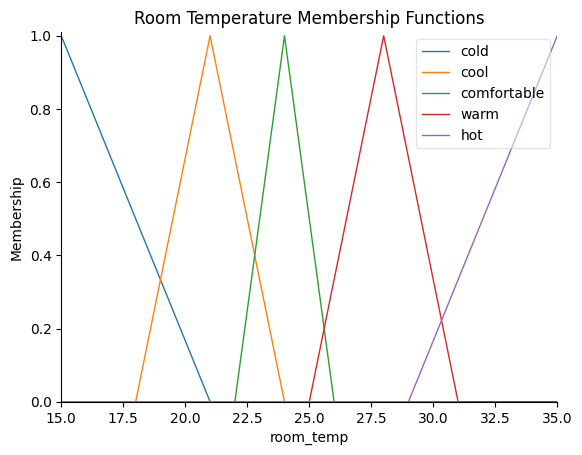

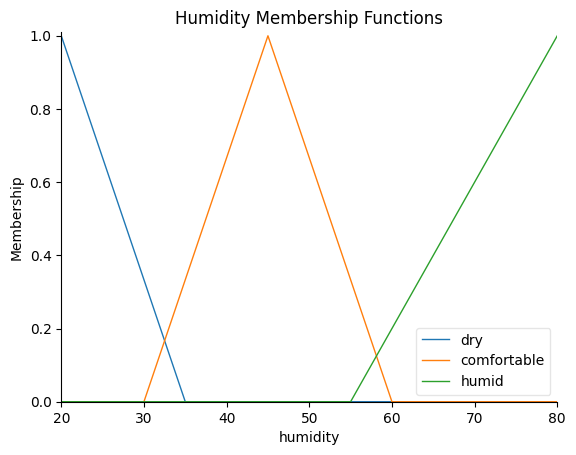

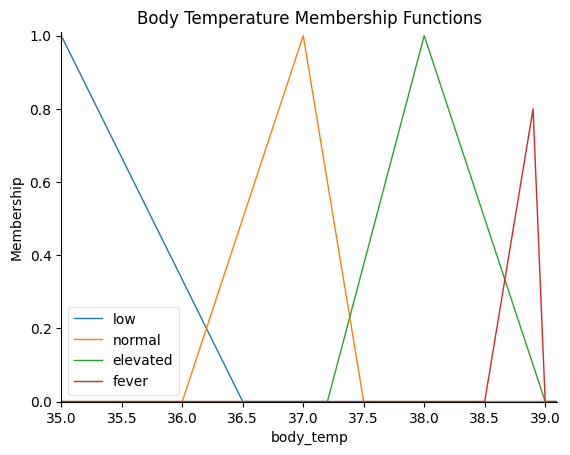

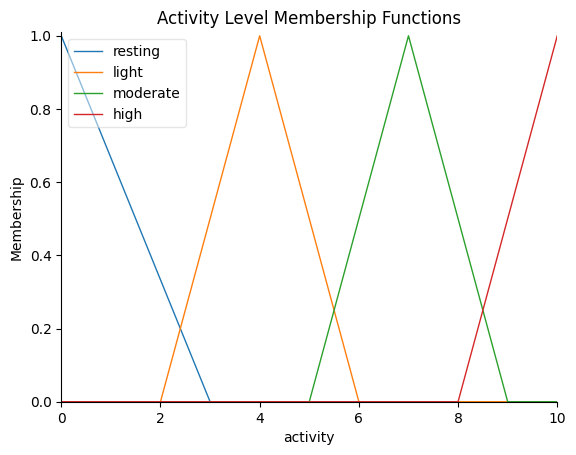

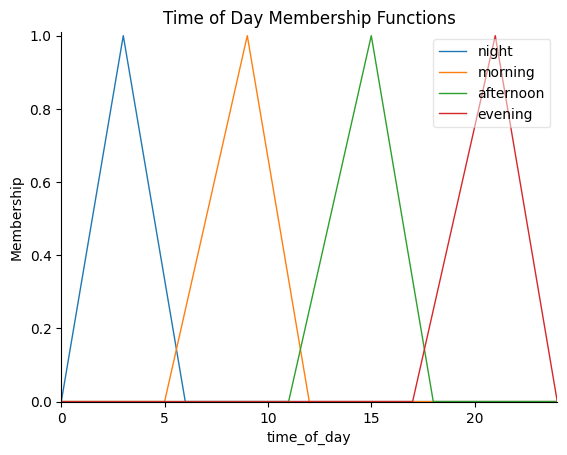

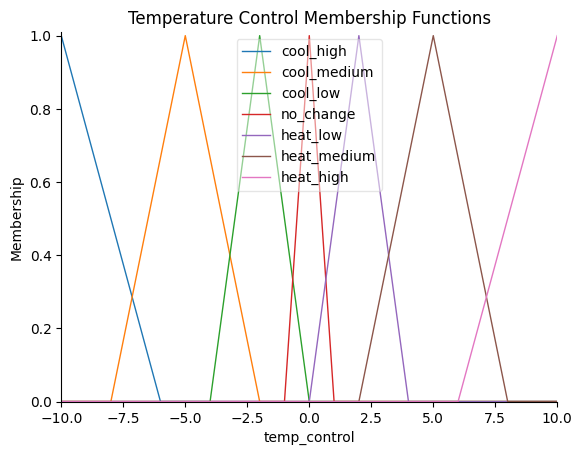

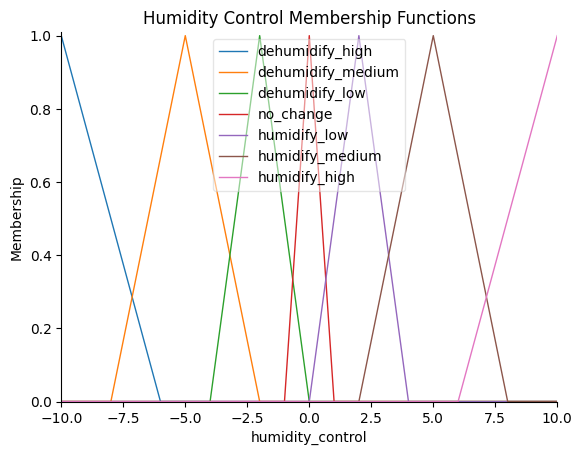

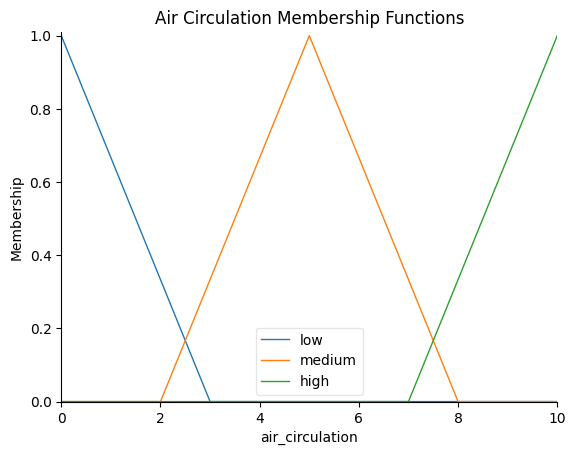

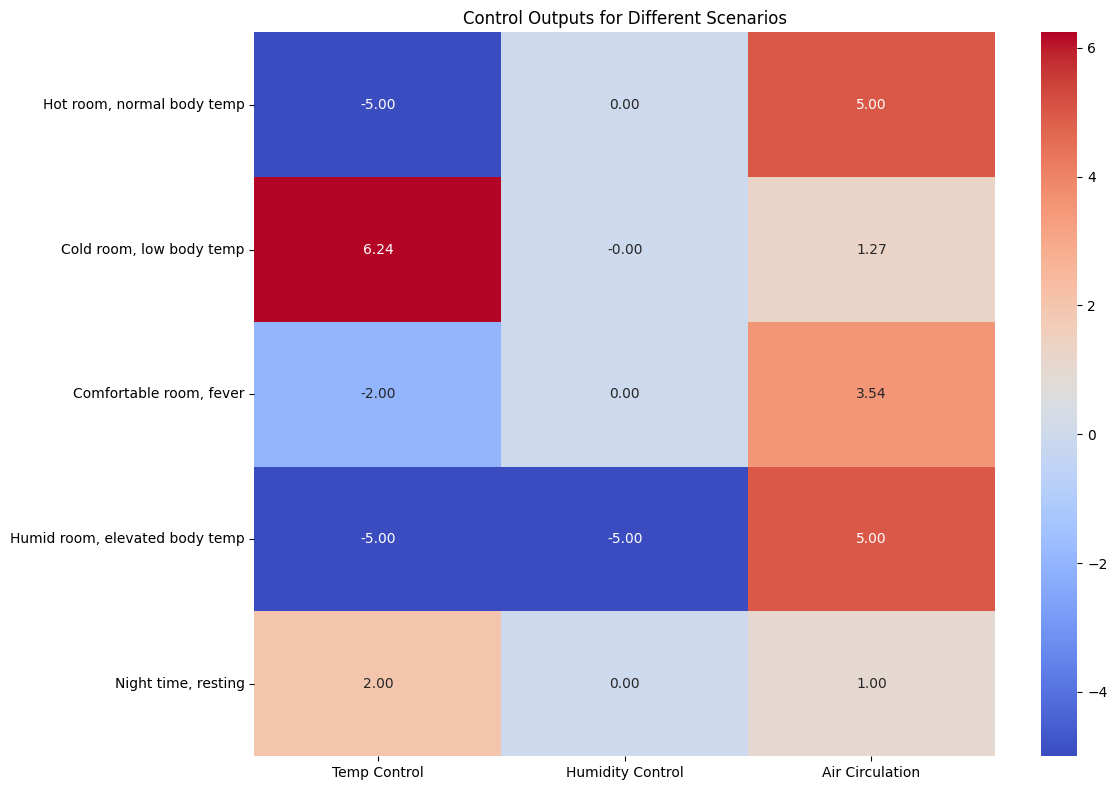

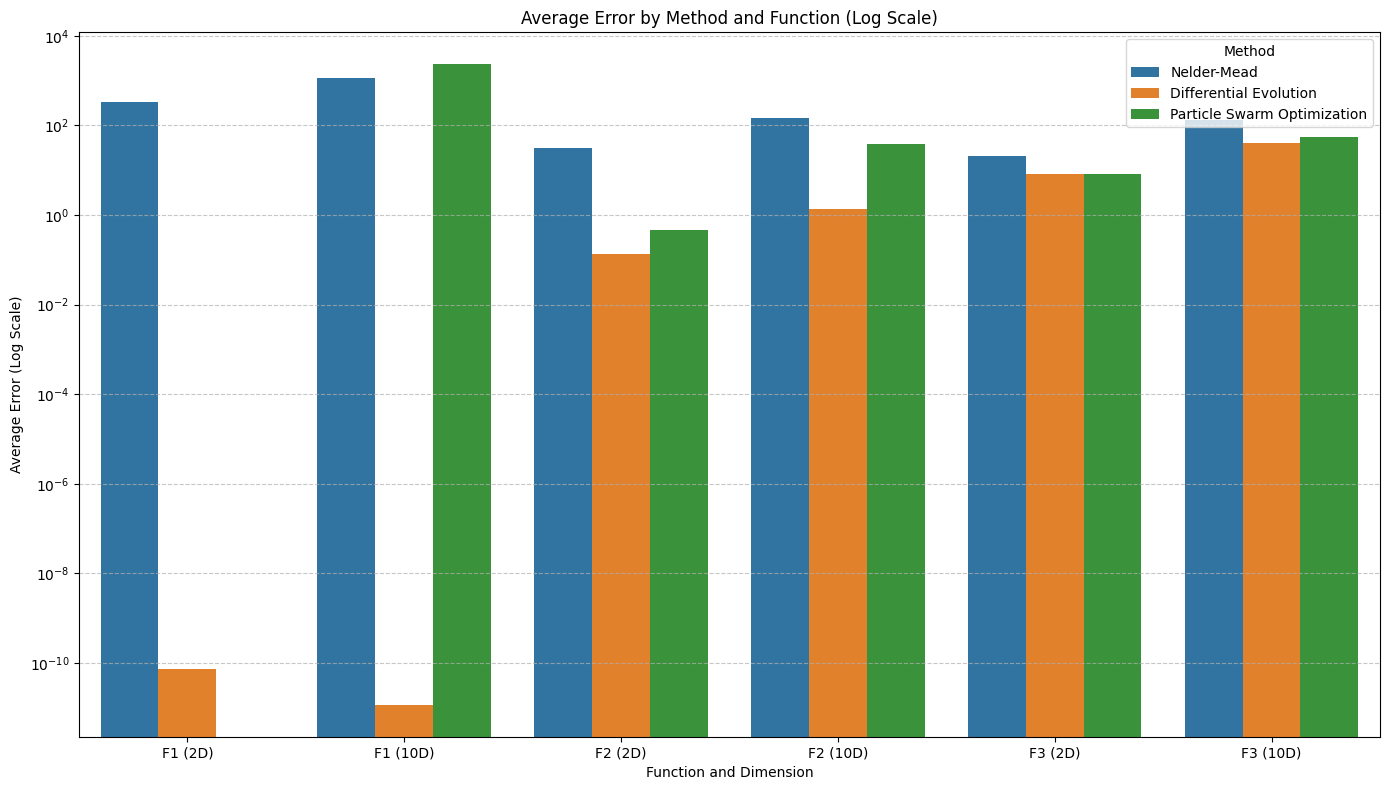

In [6]:

def run_flc_demo():
    print("Initializing Fuzzy Logic Controller for Intelligent Room Temperature Control...")
    flc = FuzzyEnvironmentController()

    print("Plotting membership functions...")
    flc.plot_membership_functions()

    print("Plotting control surfaces...")
    flc.plot_control_surface('room_temp', 'body_temp', 'temp_control')
    flc.plot_control_surface('room_temp', 'activity', 'temp_control')
    flc.plot_control_surface('body_temp', 'activity', 'temp_control')

    flc.plot_control_surface('humidity', 'body_temp', 'humidity_control')

    flc.plot_control_surface('activity', 'body_temp', 'air_circulation')
    flc.plot_control_surface('humidity', 'room_temp', 'air_circulation')

    print("\nSimulating different scenarios...")
    results_df = flc.simulate_scenarios()

    print("\nResults Summary:")
    print(results_df.to_string(index=False))

    results_df.to_csv('flc_scenario_results.csv', index=False)

    plt.figure(figsize=(12, 8))

    output_cols = ['Temp Control', 'Humidity Control', 'Air Circulation']
    heatmap_data = results_df[output_cols].values

    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm',
                xticklabels=output_cols, yticklabels=results_df['Scenario'])

    plt.title('Control Outputs for Different Scenarios')
    plt.tight_layout()
    plt.savefig('scenario_outputs_heatmap.png')

    print("Fuzzy Logic Controller demonstration completed. Results saved to files.")

def run_optimization_comparison():
    print("\nInitializing CEC'2005 Functions and Optimization Comparison...")
    cec = CEC2005Functions()
    opt_comp = OptimizationComparison(cec)

    print("Visualizing benchmark functions in 2D...")
    for func_id in [1, 2, 3]:
        cec.visualize_function_2d(func_id)

    print("\nRunning optimization techniques comparison...")
    results = opt_comp.run_comparison(func_ids=[1, 2, 3], dimensions=[2, 10], num_runs=15)

    results_table = opt_comp.tabulate_results(results)
    print("\nResults Summary:")
    print(results_table.to_string(index=False))

    results_table.to_csv('optimization_comparison_results.csv', index=False)

    print("\nPlotting convergence curves...")
    for func_id in [1, 2, 3]:
        for dim in [2, 10]:
            try:
                opt_comp.plot_convergence(func_id, dim)
            except Exception as e:
                print(f"Error plotting convergence for F{func_id} in {dim}D: {str(e)}")


    plt.figure(figsize=(14, 8))

    pivot_data = results_table.copy()
    pivot_data['Avg Error'] = pivot_data['Avg Error'].apply(lambda x: float(x.split('e')[0]) * 10**float(x.split('e')[1]))

    ax = sns.barplot(x='Function', y='Avg Error', hue='Method', data=pivot_data)

    plt.yscale('log')

    plt.title('Average Error by Method and Function (Log Scale)')
    plt.xlabel('Function and Dimension')
    plt.ylabel('Average Error (Log Scale)')
    plt.legend(title='Method')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.savefig('avg_error_by_method_function.png')

    print("Optimization comparison completed. Results saved to files.")

if __name__ == "__main__":
    run_flc_demo()

    run_optimization_comparison()